In [ ]:
!pip install "datasets<4.0.0" sacrebleu pyvi

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 51.8/51.8 kB 3.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 491.5/491.5 kB 17.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 104.1/104.1 kB 6.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.5/8.5 MB 108.6 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 7.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 193.6/193.6 kB 14.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 146.7/146.7 kB 12.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 63.6 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2025.10.0
    Uninstalling fsspec-2025.10.0:
      Successfully uninstalled fsspec-2025.10.0
  Attempting uninstall: dill
    Found existing installation: dill 0.4.0
    Uninstalling dill-0.4.0:
      Successfully uninstalled dill-0.4.0
  Attempting uninstall: multiprocess
    Fou

In [ ]:
# --- 1. Thư viện chuẩn (Standard Library) ---
import math
import time
import re
import warnings
from collections import Counter

# --- 2. Thư viện Xử lý dữ liệu & Tính toán (Data & Math) ---
import numpy as np
import pandas as pd
from tqdm import tqdm  # Thanh tiến trình

# --- 3. Thư viện Trực quan hóa (Visualization) ---
import matplotlib.pyplot as plt
import seaborn as sns

# --- 4. Thư viện PyTorch (Deep Learning Core) ---
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

# --- 5. Thư viện NLP & Đánh giá (NLP & Metrics) ---
from datasets import load_dataset       # HuggingFace Datasets
from pyvi import ViTokenizer            # Tokenizer tiếng Việt
import sacrebleu                        # Đánh giá điểm BLEU chuẩn
from nltk.translate.bleu_score import ( # Đánh giá BLEU từ NLTK
    corpus_bleu, 
    sentence_bleu, 
    SmoothingFunction
)

# Thiết lập: Bỏ qua các cảnh báo không cần thiết để output sạch đẹp
warnings.filterwarnings('ignore')

# Thiết lập device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


# **Tiền xử lý dữ liệu**

Loading dataset...


README.md:   0%|          | 0.00/665 [00:00<?, ?B/s]

data/train-00000-of-00001-8fc21cb8e80d3a(…):   0%|          | 0.00/11.3M [00:00<?, ?B/s]

data/test-00000-of-00001-858c0e989d9c563(…):   0%|          | 0.00/1.42M [00:00<?, ?B/s]

data/valid-00000-of-00001-99e7e50144d1c1(…):   0%|          | 0.00/1.42M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/203272 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/25409 [00:00<?, ? examples/s]

Generating valid split:   0%|          | 0/25409 [00:00<?, ? examples/s]

Đang tính toán thống kê độ dài câu...


Analyzing length: 100%|██████████| 203272/203272 [00:35<00:00, 5710.82it/s]



========== KẾT QUẢ PHÂN TÍCH ==========
Tiếng Anh (Source): Max=47, Avg=7.1, 99% < 16 từ
Tiếng Việt (Target): Max=50, Avg=7.1, 99% < 16 từ


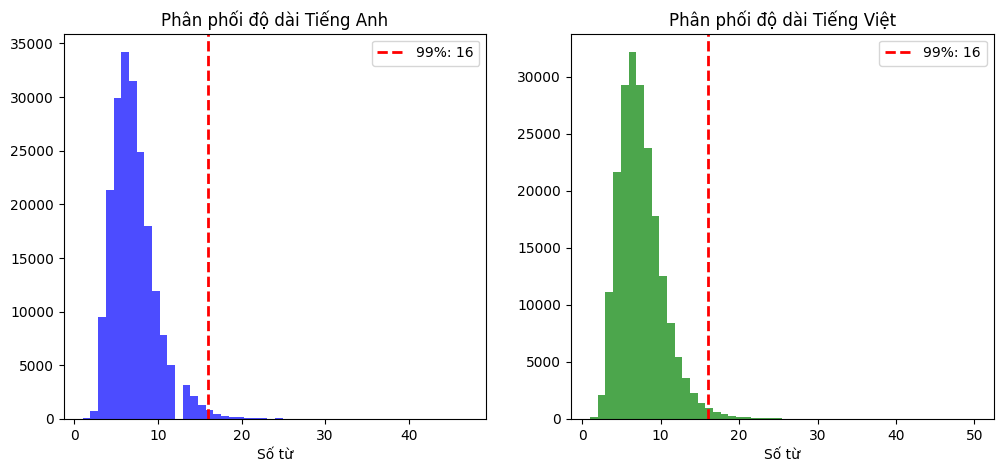

Building vocab...


Building vocab vi: 100%|██████████| 203272/203272 [00:32<00:00, 6188.88it/s]


Vocab Size - EN: 9701 | VI: 6822
Initializing Datasets...
Processing data (Pre-tokenization) with Max Len 64...


Pre-processing: 100%|██████████| 203272/203272 [00:50<00:00, 4018.81it/s]


Processing data (Pre-tokenization) with Max Len 64...


Pre-processing: 100%|██████████| 25409/25409 [00:06<00:00, 4034.17it/s]


In [ ]:
# Load dataset
print("Loading dataset...")
raw_datasets = load_dataset("harouzie/vi_en-translation")
train_data_raw = raw_datasets["train"]

# Chia validation nếu chưa có
if "valid" in raw_datasets:
    val_data_raw = raw_datasets["valid"]
elif "test" in raw_datasets:
    val_data_raw = raw_datasets["test"]
else:
    train_val = raw_datasets["train"].train_test_split(test_size=0.05)
    train_data_raw = train_val["train"]
    val_data_raw = train_val["test"]

# Hàm clean text
CONTRACTIONS = { 
    "aren't": "are not", "can't": "cannot", "couldn't": "could not",
    "didn't": "did not", "doesn't": "does not", "don't": "do not",
    "hadn't": "had not", "hasn't": "has not", "haven't": "have not",
    "he'd": "he would", "he'll": "he will", "he's": "he is",
    "i'd": "i would", "i'll": "i will", "i'm": "i am", "i've": "i have",
    "isn't": "is not", "it's": "it is", "let's": "let us",
    "mustn't": "must not", "shan't": "shall not", "she'd": "she would",
    "she'll": "she will", "she's": "she is", "shouldn't": "should not",
    "that's": "that is", "there's": "there is", "they'd": "they would",
    "they'll": "they will", "they're": "they are", "they've": "they have",
    "we'd": "we would", "we're": "we are", "we've": "we have",
    "weren't": "were not", "what'll": "what will", "what're": "what are",
    "what's": "what is", "what've": "what have", "where's": "where is",
    "who'd": "who would", "who'll": "who will", "who're": "who are",
    "who's": "who is", "who've": "who have", "won't": "will not",
    "wouldn't": "would not", "you'd": "you would", "you'll": "you will",
    "you're": "you are", "you've": "you have",
    "'re": " are", "'s": " is", "'d": " would", "'ll": " will", "'t": " not",
    "'ve": " have", "'m": " am"
}

def clean_text(text, lang="en"):
    text = str(text).lower() # Đảm bảo là string
    if lang == "en":
        for contraction, expansion in CONTRACTIONS.items():
            if contraction in text:
                text = text.replace(contraction, expansion)
    text = re.sub(r"[^a-z0-9àáạảãâầấậẩẫăằắặẳẵèéẹẻẽêềếệểễìíịỉĩòóọỏõôồốộổỗơờớợởỡùúụủũưừứựửữỳýỵỷỹđ\s]", " ", text)
    return " ".join(text.split())


# PHÂN TÍCH ĐỘ DÀI CÂU & CHỌN MAX_LEN
print("Đang tính toán thống kê độ dài câu...")

src_lens = []
tgt_lens = []

# Duyệt qua toàn bộ tập train để đếm số từ
for item in tqdm(train_data_raw, desc="Analyzing length"):
    # Tiếng Anh (Source)
    src_text = clean_text(item["English"], lang="en")
    src_lens.append(len(src_text.split()))
    
    # Tiếng Việt (Target) - Cần tokenize để đếm đúng từ ghép
    tgt_text = clean_text(item["Vietnamese"], lang="vi")
    tgt_text = ViTokenizer.tokenize(tgt_text) 
    tgt_lens.append(len(tgt_text.split()))

# Tính các chỉ số thống kê
src_99 = np.percentile(src_lens, 99)
tgt_99 = np.percentile(tgt_lens, 99)
src_max = max(src_lens)
tgt_max = max(tgt_lens)

print(f"\n{'='*10} KẾT QUẢ PHÂN TÍCH {'='*10}")
print(f"Tiếng Anh (Source): Max={src_max}, Avg={np.mean(src_lens):.1f}, 99% < {int(src_99)} từ")
print(f"Tiếng Việt (Target): Max={tgt_max}, Avg={np.mean(tgt_lens):.1f}, 99% < {int(tgt_99)} từ")
print(f"{'='*40}")

# Vẽ biểu đồ
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.hist(src_lens, bins=50, color='blue', alpha=0.7)
plt.axvline(src_99, color='red', linestyle='dashed', linewidth=2, label=f'99%: {int(src_99)}')
plt.title("Phân phối độ dài Tiếng Anh")
plt.xlabel("Số từ")
plt.legend()

plt.subplot(1, 2, 2)
plt.hist(tgt_lens, bins=50, color='green', alpha=0.7)
plt.axvline(tgt_99, color='red', linestyle='dashed', linewidth=2, label=f'99%: {int(tgt_99)}')
plt.title("Phân phối độ dài Tiếng Việt")
plt.xlabel("Số từ")
plt.legend()

plt.show()

# --- LÝ DO CHỌN MAX_LEN = 64 ---
# Mặc dù 99% dữ liệu chỉ dài khoảng 16-18 từ, nhưng ta chọn 64 vì:
# 1. AN TOÀN: Dữ liệu thực tế có câu dài tới 50 từ (Max=50). Nếu chọn 18, ta sẽ cắt cụt 
#    và làm hỏng ý nghĩa của các câu dài quan trọng này.
# 2. HIỆU NĂNG: GPU xử lý ma trận kích thước lũy thừa của 2 (32, 64, 128) nhanh hơn số lẻ.
# 3. PADDING: Việc thêm số 0 (padding) vào câu ngắn không tốn nhiều tài nguyên tính toán 
#    nhờ cơ chế Masking của Transformer.

# BUILD VOCAB (Sửa lỗi lặp update)
def build_vocab(data, lang_key, min_freq=3):
    counter = Counter()
    for ex in tqdm(data, desc=f"Building vocab {lang_key}"):
        sent = ex["English"] if lang_key == "en" else ex["Vietnamese"]
        
        # Clean
        sent = clean_text(sent, lang=lang_key)
        
        # Tokenize (chỉ tokenize tiếng Việt, tiếng Anh thì split space)
        if lang_key == "vi":
            sent = ViTokenizer.tokenize(sent)
            
        counter.update(sent.split())
    
    vocab = {"<pad>": 0, "<bos>": 1, "<eos>": 2, "<unk>": 3}
    for word, freq in counter.items():
        if freq >= min_freq:
            vocab[word] = len(vocab)
    return vocab

print("Building vocab...")
src_vocab = build_vocab(train_data_raw, "en")
tgt_vocab = build_vocab(train_data_raw, "vi")

src_itos = {i: w for w, i in src_vocab.items()}
tgt_itos = {i: w for w, i in tgt_vocab.items()}
print(f"Vocab Size - EN: {len(src_vocab)} | VI: {len(tgt_vocab)}")

# OPTIMIZED DATASET CLASS (QUAN TRỌNG: Pre-tokenization)

MAX_LEN = 64 

class OptimizedTranslationDataset(Dataset):
    def __init__(self, data, src_vocab, tgt_vocab, max_len=MAX_LEN):
        self.samples = []
        
        print(f"Processing data (Pre-tokenization) with Max Len {max_len}...")
        for item in tqdm(data, desc="Pre-processing"):
            # Xử lý English
            src_text = clean_text(item["English"], lang="en")
            src_tokens = src_text.split()
            src_ids = [src_vocab.get(w, src_vocab["<unk>"]) for w in src_tokens]
            
            # Xử lý Vietnamese
            tgt_text = clean_text(item["Vietnamese"], lang="vi")
            tgt_text = ViTokenizer.tokenize(tgt_text)
            tgt_tokens = tgt_text.split()
            tgt_ids = [tgt_vocab.get(w, tgt_vocab["<unk>"]) for w in tgt_tokens]
            
            # Cắt ngắn (Truncate)
            if len(src_ids) > max_len - 2: src_ids = src_ids[:max_len - 2]
            if len(tgt_ids) > max_len - 2: tgt_ids = tgt_ids[:max_len - 2]
            
            # Thêm <bos>, <eos>
            src_ids = [src_vocab["<bos>"]] + src_ids + [src_vocab["<eos>"]]
            tgt_ids = [tgt_vocab["<bos>"]] + tgt_ids + [tgt_vocab["<eos>"]]
            
            self.samples.append((torch.tensor(src_ids), torch.tensor(tgt_ids)))

    def __len__(self):
        return len(self.samples)
    
    def __getitem__(self, idx):
        return self.samples[idx]

# DATALOADERS
def collate_fn(batch):
    src_batch, tgt_batch = zip(*batch)
    # Padding với giá trị 0 (<pad>)
    src_pad = nn.utils.rnn.pad_sequence(src_batch, padding_value=0, batch_first=True)
    tgt_pad = nn.utils.rnn.pad_sequence(tgt_batch, padding_value=0, batch_first=True)
    return src_pad, tgt_pad

BATCH_SIZE = 32 

print("Initializing Datasets...")
train_ds = OptimizedTranslationDataset(train_data_raw, src_vocab, tgt_vocab)
val_ds = OptimizedTranslationDataset(val_data_raw, src_vocab, tgt_vocab)

train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True, collate_fn=collate_fn)
val_loader = DataLoader(val_ds, batch_size=BATCH_SIZE, shuffle=False, collate_fn=collate_fn)

# **Mô hình Transformer**

In [ ]:
class PositionalEncoding(nn.Module):
    def __init__(self, d_model, max_len=5000):
        super().__init__()
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        self.register_buffer('pe', pe.unsqueeze(0))

    def forward(self, x):
        return x + self.pe[:, :x.size(1)]

class MultiHeadAttention(nn.Module):
    def __init__(self, d_model, num_heads):
        super().__init__()
        assert d_model % num_heads == 0
        self.d_k = d_model // num_heads
        self.num_heads = num_heads
        self.d_model = d_model
        
        self.W_q = nn.Linear(d_model, d_model)
        self.W_k = nn.Linear(d_model, d_model)
        self.W_v = nn.Linear(d_model, d_model)
        self.W_o = nn.Linear(d_model, d_model)
        
    def scaled_dot_product_attention(self, Q, K, V, mask=None):
        attn_scores = torch.matmul(Q, K.transpose(-2, -1)) / math.sqrt(self.d_k)
        
        if mask is not None:
            attn_scores = attn_scores.masked_fill(mask == 0, -1e4)
        
        attn_probs = torch.softmax(attn_scores, dim=-1)
        output = torch.matmul(attn_probs, V)
        return output, attn_probs

    def forward(self, Q, K, V, mask=None):
        batch_size = Q.size(0)
        
        q_s = self.W_q(Q).view(batch_size, -1, self.num_heads, self.d_k).transpose(1, 2)
        k_s = self.W_k(K).view(batch_size, -1, self.num_heads, self.d_k).transpose(1, 2)
        v_s = self.W_v(V).view(batch_size, -1, self.num_heads, self.d_k).transpose(1, 2)
        
        context, attn_weights = self.scaled_dot_product_attention(q_s, k_s, v_s, mask)
        
        context = context.transpose(1, 2).contiguous().view(batch_size, -1, self.d_model)
        output = self.W_o(context)
        return output, attn_weights

class PositionwiseFeedForward(nn.Module):
    def __init__(self, d_model, d_ff):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(d_model, d_ff),
            nn.ReLU(),
            nn.Linear(d_ff, d_model)
        )
    def forward(self, x): return self.net(x)

class EncoderLayer(nn.Module):
    def __init__(self, d_model, num_heads, d_ff, dropout=0.1):
        super().__init__()
        self.self_attn = MultiHeadAttention(d_model, num_heads)
        self.ffn = PositionwiseFeedForward(d_model, d_ff)
        self.norm1 = nn.LayerNorm(d_model)
        self.norm2 = nn.LayerNorm(d_model)
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, x, mask):
        attn_out, weights = self.self_attn(x, x, x, mask)
        x = self.norm1(x + self.dropout(attn_out))
        ffn_out = self.ffn(x)
        x = self.norm2(x + self.dropout(ffn_out))
        return x, weights

class DecoderLayer(nn.Module):
    def __init__(self, d_model, num_heads, d_ff, dropout=0.1):
        super().__init__()
        self.self_attn = MultiHeadAttention(d_model, num_heads)
        self.cross_attn = MultiHeadAttention(d_model, num_heads)
        self.ffn = PositionwiseFeedForward(d_model, d_ff)
        self.norm1 = nn.LayerNorm(d_model)
        self.norm2 = nn.LayerNorm(d_model)
        self.norm3 = nn.LayerNorm(d_model)
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, x, enc_output, src_mask, tgt_mask):
        sa_out, sa_weights = self.self_attn(x, x, x, tgt_mask)
        x = self.norm1(x + self.dropout(sa_out))
        
        ca_out, ca_weights = self.cross_attn(x, enc_output, enc_output, src_mask)
        x = self.norm2(x + self.dropout(ca_out))
        
        ffn_out = self.ffn(x)
        x = self.norm3(x + self.dropout(ffn_out))
        return x, sa_weights, ca_weights

class Transformer(nn.Module):
    def __init__(self, src_vocab_size, tgt_vocab_size, d_model=256, num_heads=8, num_layers=3, d_ff=512, dropout=0.1):
        super().__init__()
        self.enc_emb = nn.Embedding(src_vocab_size, d_model)
        self.enc_pe = PositionalEncoding(d_model)
        self.enc_layers = nn.ModuleList([EncoderLayer(d_model, num_heads, d_ff, dropout) for _ in range(num_layers)])
        
        self.dec_emb = nn.Embedding(tgt_vocab_size, d_model)
        self.dec_pe = PositionalEncoding(d_model)
        self.dec_layers = nn.ModuleList([DecoderLayer(d_model, num_heads, d_ff, dropout) for _ in range(num_layers)])
        
        self.fc_out = nn.Linear(d_model, tgt_vocab_size)
        self.dropout = nn.Dropout(dropout)
        
    def make_src_mask(self, src):
        return (src != 0).unsqueeze(1).unsqueeze(2)
    
    def make_tgt_mask(self, tgt):
        pad_mask = (tgt != 0).unsqueeze(1).unsqueeze(2)
        len_tgt = tgt.size(1)
        sub_mask = torch.tril(torch.ones((len_tgt, len_tgt), device=tgt.device)).bool()
        return pad_mask & sub_mask
        
    def encode(self, src, src_mask):
        x = self.dropout(self.enc_pe(self.enc_emb(src)))
        enc_weights = []
        for layer in self.enc_layers:
            x, w = layer(x, src_mask)
            enc_weights.append(w)
        return x, enc_weights
    
    def decode(self, tgt, enc_output, src_mask, tgt_mask):
        x = self.dropout(self.dec_pe(self.dec_emb(tgt)))
        dec_weights = []
        for layer in self.dec_layers:
            x, sa_w, ca_w = layer(x, enc_output, src_mask, tgt_mask)
            dec_weights.append((sa_w, ca_w))
        return x, dec_weights

    def forward(self, src, tgt):
        src_mask = self.make_src_mask(src)
        tgt_mask = self.make_tgt_mask(tgt)
        enc_output, _ = self.encode(src, src_mask)
        dec_output, _ = self.decode(tgt, enc_output, src_mask, tgt_mask)
        return self.fc_out(dec_output)
    
    def get_attention_maps(self, src, tgt):
        src_mask = self.make_src_mask(src)
        tgt_mask = self.make_tgt_mask(tgt)
        enc_output, enc_w = self.encode(src, src_mask)
        dec_output, dec_w = self.decode(tgt, enc_output, src_mask, tgt_mask)
        return enc_w, dec_w

# **Cấu hình (Training Configuration)**

In [ ]:
# Hyperparameters
D_MODEL = 256
NUM_HEADS = 4
NUM_LAYERS = 3
D_FF = 1024
DROPOUT = 0.1
EPOCHS = 10
LEARNING_RATE = 1e-4

# Khởi tạo Model
model = Transformer(
    src_vocab_size=len(src_vocab),
    tgt_vocab_size=len(tgt_vocab),
    d_model=D_MODEL,
    num_heads=NUM_HEADS,
    num_layers=NUM_LAYERS,
    d_ff=D_FF,
    dropout=DROPOUT
).to(device)

# Loss & Optimizer
criterion = nn.CrossEntropyLoss(ignore_index=0, label_smoothing=0.1)
optimizer = optim.Adam(model.parameters(), lr=0, betas=(0.9, 0.98), eps=1e-9)

# Scheduler
class NoamScheduler:
    def __init__(self, optimizer, d_model, warmup_steps=4000):
        self.optimizer = optimizer
        self.d_model = d_model
        self.warmup_steps = warmup_steps
        self.step_num = 0
    def step(self):
        self.step_num += 1
        lr = (self.d_model ** -0.5) * min(self.step_num ** -0.5, self.step_num * (self.warmup_steps ** -1.5))
        for p in self.optimizer.param_groups: p['lr'] = lr

scheduler = NoamScheduler(optimizer, D_MODEL, warmup_steps=4000)

# Scaler cho Mixed Precision
try:
    # PyTorch mới
    scaler = torch.amp.GradScaler('cuda')
except:
    # PyTorch cũ
    scaler = torch.cuda.amp.GradScaler()

# **Hàm Huấn luyện & Đánh giá (Loops)**

In [ ]:
def calculate_accuracy(logits, targets, ignore_index=0):
    # Logits: [Batch, SeqLen, Vocab] hoặc [Batch*SeqLen, Vocab]
    # Targets: [Batch, SeqLen] hoặc [Batch*SeqLen]
    
    # Lấy chỉ số của từ có xác suất cao nhất
    pred = logits.argmax(dim=-1)
    
    # Flatten ra thành 1 chiều để so sánh
    pred = pred.reshape(-1)
    targets = targets.reshape(-1)
    
    # Tạo mask để bỏ qua padding (không tính padding vào độ chính xác)
    mask = targets != ignore_index
    
    # Tính số từ đoán đúng
    correct = (pred == targets) & mask
    
    # Trả về tỷ lệ đúng (trên tổng số từ không phải padding)
    if mask.sum() == 0:
        return 0.0
    return correct.sum().float() / mask.sum().float()

def train_epoch(model, loader, optimizer, criterion, scheduler, scaler, accum_iter=4):
    model.train()
    total_loss = 0
    total_acc = 0
    
    optimizer.zero_grad() 
    
    pbar = tqdm(loader, desc="Training", mininterval=1.0)
    
    for i, (src, tgt) in enumerate(pbar):
        src, tgt = src.to(device), tgt.to(device)
        tgt_input = tgt[:, :-1]
        tgt_output = tgt[:, 1:]
        
        try:
            context = torch.amp.autocast('cuda')
        except:
            context = torch.cuda.amp.autocast()

        with context:
            logits = model(src, tgt_input)
            loss = criterion(logits.reshape(-1, logits.shape[-1]), tgt_output.reshape(-1))
            
            loss = loss / accum_iter 
        
        scaler.scale(loss).backward()
        
        if (i + 1) % accum_iter == 0:
            scaler.step(optimizer)
            scaler.update()
            optimizer.zero_grad()
            scheduler.step()
        
        with torch.no_grad():
            acc = calculate_accuracy(logits, tgt_output)
            
        total_loss += loss.item() * accum_iter
        total_acc += acc.item()
        
        pbar.set_postfix(loss=f"{total_loss / (i+1):.4f}", acc=f"{total_acc / (i+1):.4f}")
        
    return total_loss / len(loader), total_acc / len(loader)

def evaluate(model, loader, criterion):
    model.eval()
    total_loss = 0
    total_acc = 0 
    
    with torch.no_grad():
        for src, tgt in loader:
            src, tgt = src.to(device), tgt.to(device)
            tgt_input = tgt[:, :-1]
            tgt_output = tgt[:, 1:]
            
            try:
                context = torch.amp.autocast('cuda')
            except:
                context = torch.cuda.amp.autocast()
            
            with context:
                logits = model(src, tgt_input)
                loss = criterion(logits.reshape(-1, logits.shape[-1]), tgt_output.reshape(-1))
            
            # Tính Accuracy
            acc = calculate_accuracy(logits, tgt_output)
            
            total_loss += loss.item()
            total_acc += acc.item()
            
    return total_loss / len(loader), total_acc / len(loader)

# **Utils (Dịch, BLEU, Vẽ Hình)**

In [ ]:
# Hàm xóa dấu gạch dưới
def post_process(text):
    return text.replace("_", " ")

def greedy_decode(model, src, max_len=64):
    model.eval()
    src = src.to(device)
    src_mask = model.make_src_mask(src)
    enc_output, _ = model.encode(src, src_mask)
    
    tgt = torch.ones(1, 1).fill_(tgt_vocab["<bos>"]).type(torch.long).to(device)
    
    for _ in range(max_len):
        tgt_mask = model.make_tgt_mask(tgt)
        out, _ = model.decode(tgt, enc_output, src_mask, tgt_mask)
        prob = model.fc_out(out[:, -1])
        _, next_word = torch.max(prob, dim=1)
        next_word = next_word.item()
        
        # Nối từ mới vào chuỗi
        tgt = torch.cat([tgt, torch.ones(1, 1).type_as(src).fill_(next_word)], dim=1)
        if next_word == tgt_vocab["<eos>"]: 
            break
            
    return tgt

def translate_sentence(sentence, model, use_beam=False):
    model.eval()
    
    # Clean text đầu vào
    sentence = clean_text(sentence, lang="en")
    
    tokens = [src_vocab["<bos>"]] + [src_vocab.get(t, src_vocab["<unk>"]) for t in sentence.split()] + [src_vocab["<eos>"]]
    src_tensor = torch.tensor(tokens).unsqueeze(0).to(device)
    
    if use_beam:
        tgt_tensor = beam_search_decode(model, src_tensor, beam_width=3, max_len=64)
    else:
        tgt_tensor = greedy_decode(model, src_tensor, max_len=64)
        
    result = []
    # Xử lý output tensor
    if tgt_tensor.dim() > 1:
        tgt_indices = tgt_tensor.squeeze().tolist()
    else:
        tgt_indices = tgt_tensor.tolist()

    for idx in tgt_indices:
        if idx not in [src_vocab["<bos>"], src_vocab["<eos>"], src_vocab["<pad>"]]:
            result.append(tgt_itos[idx])
            
    # Xóa dấu gạch dưới (Post-process)
    raw_text = " ".join(result)
    return post_process(raw_text)

def calculate_bleu(model, loader, limit=100):

    model.eval()
    refs, hyps = [], []
    
    # Dùng smoothing để tránh điểm 0 nếu câu quá ngắn
    chencherry = SmoothingFunction() 
    
    print(f"Đang tính BLEU trên {limit} câu validation...")
    
    with torch.no_grad():
        for i, (src, tgt) in enumerate(loader):
            if i >= limit: break
            
            # Xử lý từng câu trong batch
            for j in range(src.size(0)):
                # --- Xử lý Reference (Câu chuẩn) ---
                # Lấy các token khác 0, 1, 2
                tgt_indices = [idx.item() for idx in tgt[j] if idx.item() not in [0, 1, 2]]
                tgt_sent = " ".join([tgt_itos[idx] for idx in tgt_indices])
                # Xóa dấu "_" và tách từ lại để NLTK hiểu đúng
                tgt_sent_clean = post_process(tgt_sent).split()
                refs.append([tgt_sent_clean]) 
                
                # --- Xử lý Hypothesis (Câu máy dịch) ---
                # Lấy phần source (bỏ padding)
                src_sent_tensor = src[j][: (src[j]!=0).sum()].unsqueeze(0)
                pred_tensor = greedy_decode(model, src_sent_tensor)
                
                pred_indices = [idx.item() for idx in pred_tensor.flatten() if idx.item() not in [0, 1, 2]]
                pred_sent = " ".join([tgt_itos[idx] for idx in pred_indices])
                # Xóa dấu "_" và tách từ
                pred_sent_clean = post_process(pred_sent).split()
                hyps.append(pred_sent_clean)
                
    # Tính điểm
    score = corpus_bleu(refs, hyps, smoothing_function=chencherry.method1) * 100
    return score

def visualize_attention(sentence, model):
    model.eval()
    # Clean text trước khi đưa vào
    clean_sent = clean_text(sentence, lang="en")
    
    tokens = [src_vocab["<bos>"]] + [src_vocab.get(t, src_vocab["<unk>"]) for t in clean_sent.split()] + [src_vocab["<eos>"]]
    src_tensor = torch.tensor(tokens).unsqueeze(0).to(device)
    tgt_tensor = greedy_decode(model, src_tensor)
    
    # Lấy weights
    enc_w, dec_w = model.get_attention_maps(src_tensor, tgt_tensor[:, :-1])
    
    # Lấy attention map của layer cuối cùng, head đầu tiên
    attn_map = dec_w[-1][1][0, 0].cpu().detach().numpy() 
    
    # Nhãn trục X và Y
    src_lbl = ["<bos>"] + clean_sent.split() + ["<eos>"]
    
    # Lấy nhãn đích, loại bỏ <bos> ở đầu chuỗi decode để khớp kích thước
    tgt_lbl = []
    for i in tgt_tensor.flatten().tolist():
        if i != src_vocab["<bos>"]: # Bỏ bos
            tgt_lbl.append(tgt_itos[i])
            if i == src_vocab["<eos>"]: break # Dừng khi gặp eos
            
    # Cắt map cho khớp kích thước thực tế
    attn_map = attn_map[:len(tgt_lbl), :len(src_lbl)]
    
    plt.figure(figsize=(8,6))
    sns.heatmap(attn_map, xticklabels=src_lbl, yticklabels=tgt_lbl, cmap='viridis', annot=False)
    plt.title("Cross-Attention Map")
    plt.xlabel("Source (English)")
    plt.ylabel("Target (Vietnamese)")
    plt.show()

# **Thí nghiệm 1: Huấn luyện**

==================== TRAINING STARTED ====================


Training: 100%|██████████| 6353/6353 [03:01<00:00, 34.92it/s, acc=0.4336, loss=4.5990]


Epoch 1/10 | Time: 189s | Tr_Loss: 4.5990 Tr_Acc: 0.4336 | Val_Loss: 2.9599 Val_Acc: 0.6523 -> Saved Best!


Training: 100%|██████████| 6353/6353 [03:00<00:00, 35.22it/s, acc=0.6915, loss=2.6740]


Epoch 2/10 | Time: 188s | Tr_Loss: 2.6740 Tr_Acc: 0.6915 | Val_Loss: 2.3447 Val_Acc: 0.7491 -> Saved Best!


Training: 100%|██████████| 6353/6353 [02:59<00:00, 35.36it/s, acc=0.7500, loss=2.3203]


Epoch 3/10 | Time: 187s | Tr_Loss: 2.3203 Tr_Acc: 0.7500 | Val_Loss: 2.1683 Val_Acc: 0.7841 -> Saved Best!


Training: 100%|██████████| 6353/6353 [02:59<00:00, 35.32it/s, acc=0.7892, loss=2.1172]


Epoch 4/10 | Time: 187s | Tr_Loss: 2.1172 Tr_Acc: 0.7892 | Val_Loss: 2.0328 Val_Acc: 0.8122 -> Saved Best!


Training: 100%|██████████| 6353/6353 [03:00<00:00, 35.27it/s, acc=0.8146, loss=1.9916]


Epoch 5/10 | Time: 187s | Tr_Loss: 1.9916 Tr_Acc: 0.8146 | Val_Loss: 1.9582 Val_Acc: 0.8260 -> Saved Best!


Training: 100%|██████████| 6353/6353 [02:59<00:00, 35.32it/s, acc=0.8325, loss=1.9083]


Epoch 6/10 | Time: 187s | Tr_Loss: 1.9083 Tr_Acc: 0.8325 | Val_Loss: 1.9110 Val_Acc: 0.8354 -> Saved Best!


Training: 100%|██████████| 6353/6353 [02:59<00:00, 35.42it/s, acc=0.8446, loss=1.8505]


Epoch 7/10 | Time: 187s | Tr_Loss: 1.8505 Tr_Acc: 0.8446 | Val_Loss: 1.8854 Val_Acc: 0.8413 -> Saved Best!


Training: 100%|██████████| 6353/6353 [03:00<00:00, 35.27it/s, acc=0.8548, loss=1.8051]


Epoch 8/10 | Time: 187s | Tr_Loss: 1.8051 Tr_Acc: 0.8548 | Val_Loss: 1.8602 Val_Acc: 0.8458 -> Saved Best!


Training: 100%|██████████| 6353/6353 [02:59<00:00, 35.42it/s, acc=0.8634, loss=1.7687]


Epoch 9/10 | Time: 187s | Tr_Loss: 1.7687 Tr_Acc: 0.8634 | Val_Loss: 1.8426 Val_Acc: 0.8506 -> Saved Best!


Training: 100%|██████████| 6353/6353 [02:59<00:00, 35.41it/s, acc=0.8701, loss=1.7398]


Epoch 10/10 | Time: 187s | Tr_Loss: 1.7398 Tr_Acc: 0.8701 | Val_Loss: 1.8305 Val_Acc: 0.8539 -> Saved Best!

>>> Training Complete!


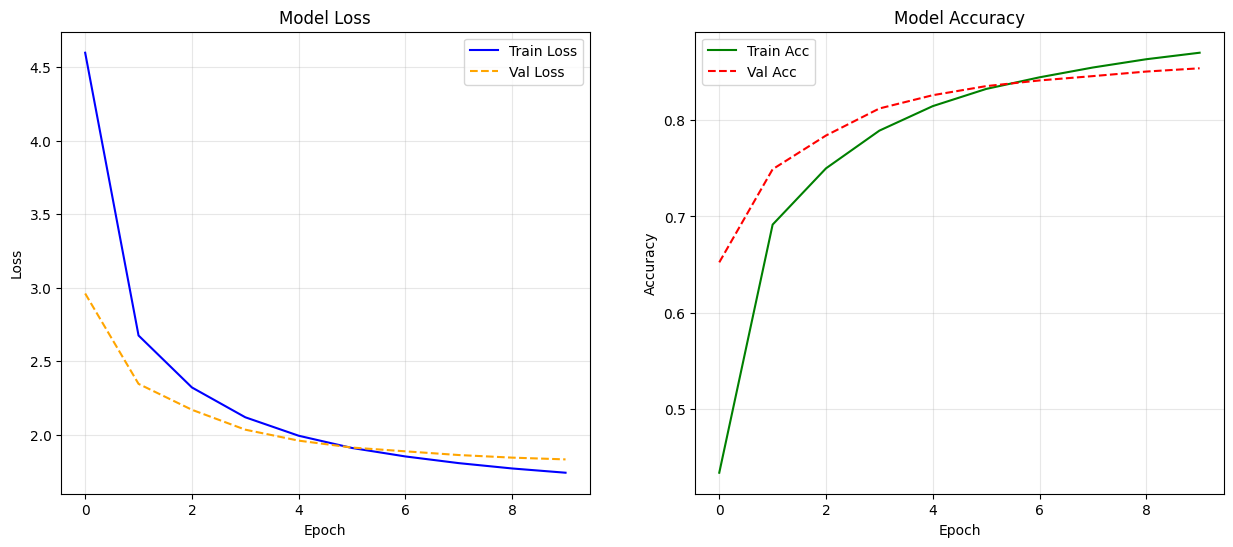

Loading best model for testing...

>>> Demo Translation:
En: I love machine learning
Vi: tôi thích máy học
---
En: Artificial intelligence is future
Vi: thông minh nhất của lòng tương lai
---
En: Can you help me translate this sentence
Vi: bạn có thể giúp tôi dịch câu này không
---
Đang tính BLEU trên 25000 câu validation...

Final BLEU Score: 68.69


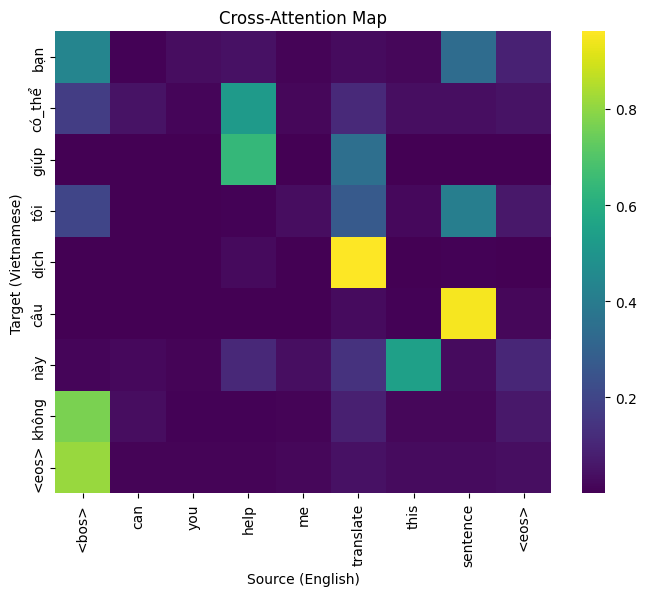

In [ ]:
if __name__ == "__main__":
    print(f"{'='*20} TRAINING STARTED {'='*20}")
    
    # Lưu lịch sử cả Train và Validation để so sánh
    train_loss_history = []
    train_acc_history = []
    val_loss_history = []
    val_acc_history = []
    
    best_val_loss = float('inf') # Để lưu model tốt nhất
    
    for epoch in range(EPOCHS):
        start = time.time()
        
        # Train & Evaluate
        tr_loss, tr_acc = train_epoch(model, train_loader, optimizer, criterion, scheduler, scaler)
        val_loss, val_acc = evaluate(model, val_loader, criterion)
        
        # Lưu lại lịch sử
        train_loss_history.append(tr_loss)
        train_acc_history.append(tr_acc)
        val_loss_history.append(val_loss)
        val_acc_history.append(val_acc)
        
        # Checkpoint: Chỉ lưu model nếu Validation Loss giảm (Tốt nhất từ trước đến giờ)
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            torch.save(model.state_dict(), "transformer_best.pth")
            save_msg = "-> Saved Best!"
        else:
            save_msg = ""
        
        # In thông tin
        print(f"Epoch {epoch+1}/{EPOCHS} | Time: {time.time()-start:.0f}s | "
              f"Tr_Loss: {tr_loss:.4f} Tr_Acc: {tr_acc:.4f} | "
              f"Val_Loss: {val_loss:.4f} Val_Acc: {val_acc:.4f} {save_msg}")
    
    # Lưu model cuối cùng (Last checkpoint)
    torch.save(model.state_dict(), "transformer_last.pth")
    print("\n>>> Training Complete!")
    
    # --- VẼ BIỂU ĐỒ (So sánh Train vs Validation) ---
    plt.figure(figsize=(15, 6))
    
    # Biểu đồ 1: Loss (Càng thấp càng tốt)
    plt.subplot(1, 2, 1)
    plt.plot(train_loss_history, label='Train Loss', color='blue')
    plt.plot(val_loss_history, label='Val Loss', color='orange', linestyle='--')
    plt.title("Model Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    # Biểu đồ 2: Accuracy (Càng cao càng tốt)
    plt.subplot(1, 2, 2)
    plt.plot(train_acc_history, label='Train Acc', color='green')
    plt.plot(val_acc_history, label='Val Acc', color='red', linestyle='--')
    plt.title("Model Accuracy")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    plt.show()

# **Thí nghiệm 2: Đánh giá chất lượng dịch**

In [ ]:
# Tải lại model tốt nhất để test 
print("Loading best model for testing...")
model.load_state_dict(torch.load("transformer_best.pth"))

# BLEU Score
bleu = calculate_bleu(model, val_loader, limit=25000) 
print(f"\nFinal BLEU Score: {bleu:.2f}")

# Demo Translate
print("\n>>> Demo Translation:")
examples = [
    "I love machine learning", 
    "Artificial intelligence is future",
    "Can you help me translate this sentence"
]
for ex in examples:
    print(f"En: {ex}\nVi: {translate_sentence(ex, model, use_beam=False)}\n---")

# **Thí nghiệm 3: Giải mã (Decode)**

In [ ]:
# greedy_decode đã được xây dựng ở phần utils nên ở đây nhóm em code thêm beam search
def beam_search_decode(model, src, beam_width=3, max_len=64):
    model.eval()
    src = src.to(device)
    src_mask = model.make_src_mask(src)
    enc_output, _ = model.encode(src, src_mask)
    
    # Khởi tạo: [(sequence, score)]
    start_token = torch.ones(1, 1).fill_(tgt_vocab["<bos>"]).type(torch.long).to(device)
    beam = [(start_token, 0.0)] 
    
    for _ in range(max_len):
        candidates = []
        
        for seq, score in beam:
            # Nếu câu đã kết thúc bằng <eos>, giữ nguyên nó
            if seq[0, -1].item() == tgt_vocab["<eos>"]:
                candidates.append((seq, score))
                continue
            
            tgt_mask = model.make_tgt_mask(seq)
            out, _ = model.decode(seq, enc_output, src_mask, tgt_mask)
            prob = model.fc_out(out[:, -1])
            log_prob = torch.log_softmax(prob, dim=1) # Log prob để cộng dồn
            
            # Lấy top k
            topk_prob, topk_idx = torch.topk(log_prob, beam_width)
            
            for i in range(beam_width):
                token = topk_idx[0, i].unsqueeze(0).unsqueeze(0)
                new_seq = torch.cat([seq, token], dim=1)
                
                # Cộng điểm (Lưu ý: log_prob là số âm, càng gần 0 càng tốt)
                new_score = score + topk_prob[0, i].item()
                candidates.append((new_seq, new_score))
        
        # Sắp xếp giảm dần theo điểm số và cắt lấy beam_width ứng viên tốt nhất
        beam = sorted(candidates, key=lambda x: x[1], reverse=True)[:beam_width]
        
        # Dừng sớm nếu ứng viên tốt nhất đã xong (Heuristic đơn giản)
        if beam[0][0][0, -1].item() == tgt_vocab["<eos>"]:
            break
            
    return beam[0][0]

# **Thí nghiệm 3: Phân tích Attention**

In [ ]:
print("\n" + "="*50)
print("THÍ NGHIỆM 4: Trực quan hóa Attention trên 2 câu từ tập validation")
print("="*50)

# Chọn ngẫu nhiên hoặc cố định 2 ví dụ từ tập validation
val_examples = [
    val_data_raw[100],   # câu thứ 100 trong validation
    val_data_raw[250],   # câu thứ 250 trong validation
]

for i, item in enumerate(val_examples, 1):
    src_sentence = item["English"]
    ref_sentence = item["Vietnamese"]
    
    print(f"\n--- Ví dụ {i} từ tập validation ---")
    print(f"English (src): {src_sentence}")
    print(f"Reference (ref): {ref_sentence}")
    
    # Dịch bằng beam search (chất lượng tốt hơn greedy)
    pred_sentence = translate_sentence(src_sentence, model, use_beam=True)
    print(f"Prediction (beam): {pred_sentence}")
    
    # Trực quan hóa attention
    print(f"\nĐang vẽ attention map cho ví dụ {i}...")
    try:
        visualize_attention(src_sentence, model)
    except Exception as e:
        print(f"Không thể vẽ attention map (lỗi: {e})")

# **Yêu cầu mở rộng: So sánh greedy decoding và beam search**

In [ ]:
pd.set_option('display.max_colwidth', None)
pd.set_option('display.width', 1000)

print(f"{'='*30}")
print(f"SO SÁNH GREEDY VS BEAM SEARCH (k=3)")
print(f"{'='*30}\n")

# 1. Dữ liệu Test
test_data = [
    # 1. Câu ngắn cơ bản (Khởi động - cả 2 thường giống nhau)
    {
        "src": "This project is very difficult",
        "ref": "dự án này rất khó"
    },
    # 2. Câu dài với cấu trúc "Tuy nhiên/Mặc dù" (Beam Search thường xử lý ngữ pháp tốt hơn)
    {
        "src": "Although the weather was very bad yesterday, we decided to go out for a walk.",
        "ref": "mặc dù thời tiết hôm qua rất xấu nhưng chúng tôi vẫn quyết định đi dạo"
    },
    # 3. Câu có mệnh đề quan hệ phức tạp (Greedy hay dịch sai thứ tự)
    {
        "src": "The student who is sitting next to the window is studying very hard for the exam.",
        "ref": "học sinh ngồi cạnh cửa sổ đang học rất chăm chỉ cho kỳ thi"
    },
    # 4. Câu trừu tượng/Kỹ thuật (Thử thách từ vựng)
    {
        "src": "Deep learning models require a significant amount of data to achieve high accuracy.",
        "ref": "các mô hình học sâu yêu cầu một lượng dữ liệu đáng kể để đạt được độ chính xác cao"
    },
    # 5. Câu dễ gây lặp (Greedy rất dễ bị lặp từ ở những câu kiểu này)
    {
        "src": "To be or not to be, that is the question.",
        "ref": "tồn tại hay không tồn tại, đó là vấn đề"
    }
]

results = []
# Khởi tạo hàm làm mượt (Smoothing) để tránh điểm 0 khi câu quá ngắn
chencherry = SmoothingFunction()

# 2. Vòng lặp chạy thử nghiệm
for item in test_data:
    sent = item["src"]
    ref_text = item["ref"]
    
    # Chuẩn bị Reference: Lowercase và split
    # Lưu ý: Reference phải là list của list các token: [['tôi', 'yêu', ...]]
    reference = [ref_text.lower().split()]
    
    # --- Cách 1: Greedy Decoding ---
    start_time = time.time()
    greedy_res = translate_sentence(sent, model, use_beam=False)
    greedy_time = time.time() - start_time
    
    # Tính BLEU cho Greedy (Có smoothing)
    greedy_bleu = sentence_bleu(reference, greedy_res.lower().split(), smoothing_function=chencherry.method1) * 100
    
    # --- Cách 2: Beam Search (k=3) ---
    start_time = time.time()
    beam_res = translate_sentence(sent, model, use_beam=True)
    beam_time = time.time() - start_time
    
    # Tính BLEU cho Beam (Có smoothing)
    beam_bleu = sentence_bleu(reference, beam_res.lower().split(), smoothing_function=chencherry.method1) * 100
    
    # Lưu kết quả
    results.append({
        "Input": sent,
        "Ref (Chuẩn)": ref_text,
        "Greedy Out": greedy_res,
        "Beam Out": beam_res,
        "BLEU G": round(greedy_bleu, 2),
        "BLEU B": round(beam_bleu, 2),
        "Time G(s)": round(greedy_time, 4),
        "Time B(s)": round(beam_time, 4)
    })

# 3. Hiển thị bảng kết quả
df = pd.DataFrame(results)
display(df)

SO SÁNH GREEDY VS BEAM SEARCH (k=3)



,Input,Ref (Chuẩn),Greedy Out,Beam Out,BLEU G,BLEU B,Time G(s),Time B(s)
0,This project is very difficult,dự án này rất khó,dự án này rất khó,dự án này rất khó,100.00,100.00,0.0323,0.0664
1,"Although the weather was very bad yesterday, we decided to go out for a walk.",mặc dù thời tiết hôm qua rất xấu nhưng chúng tôi vẫn quyết định đi dạo,mặc dù thời tiết rất xấu ngày hôm qua chúng tôi quyết định ra ngoài đi dạo,mặc dù thời tiết rất xấu ngày hôm qua chúng tôi quyết định ra ngoài đi dạo,25.02,25.02,0.0646,0.1592
2,The student who is sitting next to the window is studying very hard for the exam.,học sinh ngồi cạnh cửa sổ đang học rất chăm chỉ cho kỳ thi,sinh viên đang ngồi cạnh cửa sổ của cửa sổ rất chăm chỉ cho kỳ thi,các sinh viên đang ngồi cạnh cửa sổ rất chăm chỉ cho kỳ thi,47.92,55.65,0.0621,0.1718
3,Deep learning models require a significant amount of data to achieve high accuracy.,các mô hình học sâu yêu cầu một lượng dữ liệu đáng kể để đạt được độ chính xác cao,người học <unk> cần một lượng dữ liệu đáng kể để đạt mức độ cao,học <unk> cần một số lượng dữ liệu có ý nghĩa đáng kể để gây ra độ cao,36.92,9.14,0.0670,0.1988
4,"To be or not to be, that is the question.","tồn tại hay không tồn tại, đó là vấn đề",để hay không phải là câu hỏi đó là câu hỏi,hoặc không phải là câu hỏi đó là câu hỏi,5.64,4.94,0.0577,0.1464
